In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import torch

import constant
from constant import org_cols, wsr_cols, geo_cols, semigeo_cols
import tools
import myplot
import features
from models import MLP_Regression, train_model, timeseries_kfold_validation_training
path = "SH_SC_1/"

In [2]:
%load_ext autoreload

# Load Files

In [ ]:
settlement = pd.read_parquet(constant.settlement_train_path)
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_SH_SC_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [ ]:
len(windmill)

In [ ]:
df = pd.merge(windmill, settlement, on="GSRN")

# Feature Extraction

In [ ]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)

In [ ]:
df = features.parallelize_extract(df)

In [ ]:
df,ply_models_rn,ws_rn = features.extract_quantiles(df, "hws_uv_rn")
df,ply_models_wsr,ws_wsr = features.extract_quantiles(df, "hws_uv_wsr")

In [ ]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Parent_GSRN", "BBR_municipal", "TIME_CET", "predicted_ahead", 'UTM_x', 'UTM_y', 'VAERDI', 'max_VAERDI', 'In_service']

In [ ]:
feat = [x for x in df.columns if x not in cols_filter]
df = tools.normalize_features(df, feat)

In [ ]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])
date_s = pd.to_datetime("2019-03-01")
df_train = df[df["TIME_CET"] < date_s].sort_values(["GSRN", "TIME_CET"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s].sort_values(["TIME_CET"]).reset_index(drop=True)

In [ ]:
len(df_train)

In [ ]:
df_train.to_parquet(constant.SH_SC_TRAIN_path, index=False)
df_evl.to_parquet(constant.SH_SC_EVL_path, index=False)

# Neural Network Train

In [3]:
df_train = pd.read_parquet(constant.SH_SC_TRAIN_path)

In [4]:
target = ["VAERDI"]
n_groups=10
lr=0.001
num_epochs=50
hidden_size = 1000
output_size = 1

## Original Features


In [9]:
model_original = MLP_Regression(
  input_size=45,
  hidden_size=hidden_size
)

### Timeserise K-Fold-Validation

In [10]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=org_cols, target=target, n_groups=n_groups, model=model_original, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.08327329158782959 test loss: 0.06682654470205307
Epoch 10 train loss: 0.05261353775858879 test loss: 0.05199529230594635
Epoch 20 train loss: 0.05069632828235626 test loss: 0.05411268770694733
Epoch 30 train loss: 0.04862387850880623 test loss: 0.05387810617685318
Epoch 40 train loss: 0.04714931920170784 test loss: 0.052905745804309845
Epoch 49 train loss: 0.04592619091272354 test loss: 0.05184176564216614
Epoch 0 train loss: 0.04902377352118492 test loss: 0.022469159215688705
Epoch 10 train loss: 0.04772394895553589 test loss: 0.022242160513997078
Epoch 20 train loss: 0.04595763608813286 test loss: 0.022138051688671112
Epoch 30 train loss: 0.04391394555568695 test loss: 0.0213315412402153
Epoch 40 train loss: 0.041704561561346054 test loss: 0.020966408774256706
Epoch 49 train loss: 0.03967918083071709 test loss: 0.020643126219511032
Epoch 0 train loss: 0.039070066064596176 test loss: 0.024223720654845238
Epoch 10 train loss: 0.038494836539030075 test loss: 0.0255

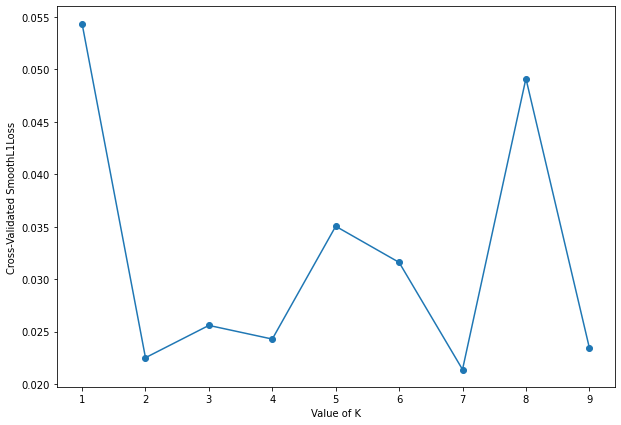

<Figure size 432x288 with 0 Axes>

In [11]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"original_k_fold.png")

### Train model

In [ ]:
x_train, y_train = df_train[org_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [13]:
model_original, train_hist_original, _ = train_model(
                                            model_original, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"original_model.pth")

Epoch 0 train loss: 0.021815061569213867
Epoch 10 train loss: 0.021982690319418907
Epoch 20 train loss: 0.021803930401802063
Epoch 30 train loss: 0.02147478610277176
Epoch 40 train loss: 0.021307330578565598


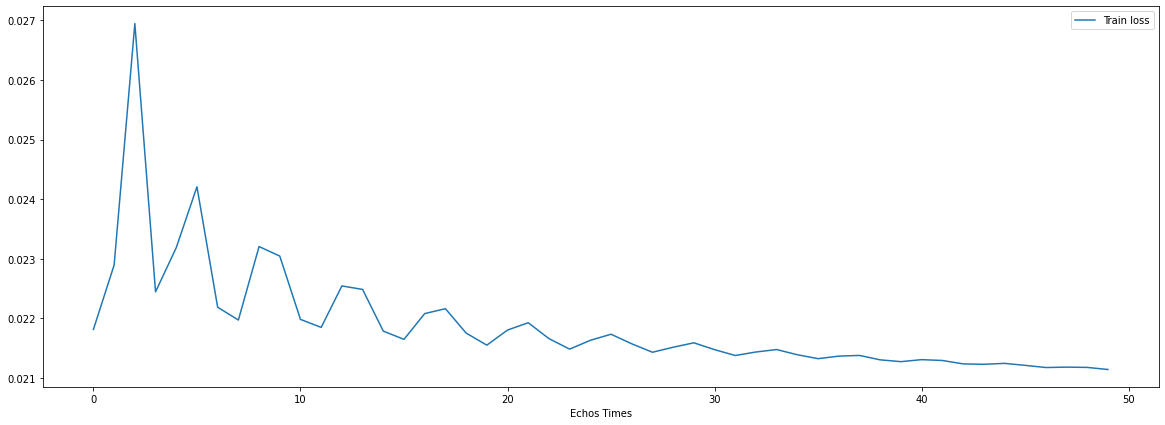

In [14]:
myplot.model_loss({"Train loss":train_hist_original}, save_name=path+"original_loss.png")

## Windshear Features

In [16]:
model_wsr = MLP_Regression(
  input_size=47,
  hidden_size=hidden_size
)

In [17]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=wsr_cols, target=target, n_groups=n_groups, model=model_wsr, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.11271101981401443 test loss: 0.10535162687301636
Epoch 10 train loss: 0.03960718214511871 test loss: 0.04018493369221687
Epoch 20 train loss: 0.030644865706562996 test loss: 0.030381424352526665
Epoch 30 train loss: 0.030455781146883965 test loss: 0.028639597818255424
Epoch 40 train loss: 0.029705945402383804 test loss: 0.028460126370191574
Epoch 49 train loss: 0.029308658093214035 test loss: 0.028150679543614388
Epoch 0 train loss: 0.03061084635555744 test loss: 0.01618223264813423
Epoch 10 train loss: 0.030556373298168182 test loss: 0.01837318390607834
Epoch 20 train loss: 0.029890621080994606 test loss: 0.018282637000083923
Epoch 30 train loss: 0.029312284663319588 test loss: 0.017621411010622978
Epoch 40 train loss: 0.02881988324224949 test loss: 0.017330661416053772
Epoch 49 train loss: 0.02840994857251644 test loss: 0.017230737954378128
Epoch 0 train loss: 0.028884282335639 test loss: 0.01230856217443943
Epoch 10 train loss: 0.029365750029683113 test loss: 0

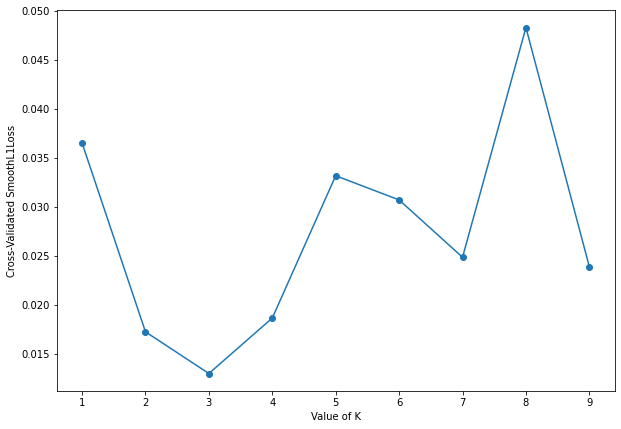

<Figure size 432x288 with 0 Axes>

In [19]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"wsr_k_fold.png")

### Train model

In [22]:
x_train, y_train = df_train[wsr_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [25]:
model_wsr, train_hist_wsr, _ = train_model(model_wsr, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"wsr_model.pth")

Epoch 0 train loss: 0.02262912318110466
Epoch 10 train loss: 0.02480640821158886
Epoch 20 train loss: 0.022944949567317963
Epoch 30 train loss: 0.022484466433525085
Epoch 40 train loss: 0.022428831085562706


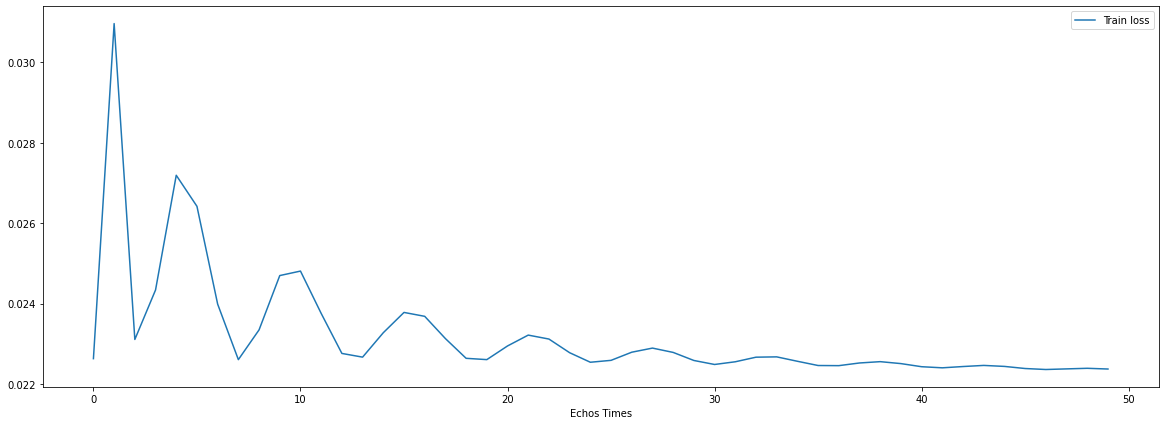

In [26]:
myplot.model_loss({"Train loss":train_hist_wsr}, save_name=path+"wsr_loss.png")

## Geo Features

In [28]:
model_geo = MLP_Regression(
  input_size=49,
  hidden_size=hidden_size
)

In [29]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=geo_cols, target=target, n_groups=n_groups, model=model_geo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.11598406732082367 test loss: 0.1101895198225975
Epoch 10 train loss: 0.03771687299013138 test loss: 0.033058978617191315
Epoch 20 train loss: 0.026140866801142693 test loss: 0.02914794534444809
Epoch 30 train loss: 0.02414412423968315 test loss: 0.02292848378419876
Epoch 40 train loss: 0.02336476929485798 test loss: 0.02151574194431305
Epoch 49 train loss: 0.022990087047219276 test loss: 0.020917341113090515
Epoch 0 train loss: 0.02392604760825634 test loss: 0.012622435577213764
Epoch 10 train loss: 0.024214597418904305 test loss: 0.014311574399471283
Epoch 20 train loss: 0.023471733555197716 test loss: 0.013928337953984737
Epoch 30 train loss: 0.022880729287862778 test loss: 0.013258954510092735
Epoch 40 train loss: 0.022474773228168488 test loss: 0.013066872023046017
Epoch 49 train loss: 0.022168533876538277 test loss: 0.013043512590229511
Epoch 0 train loss: 0.022564947605133057 test loss: 0.009181281551718712
Epoch 10 train loss: 0.023418819531798363 test loss

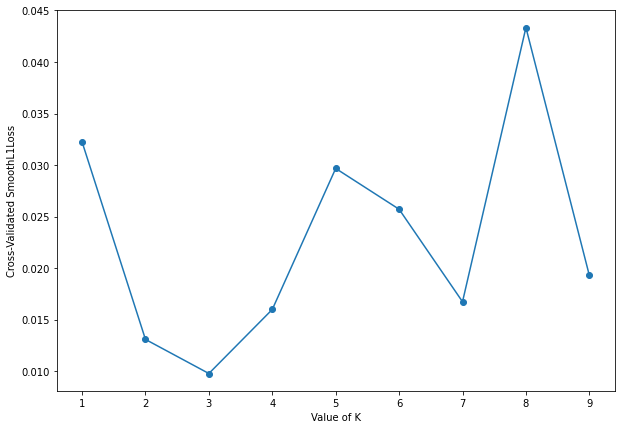

<Figure size 432x288 with 0 Axes>

In [30]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"geo_k_fold.png")

### Train model

In [31]:
x_train, y_train = df_train[geo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [32]:
model_geo, train_hist_geo, _ = train_model(model_geo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"geo_model.pth")

Epoch 0 train loss: 0.019437480717897415
Epoch 10 train loss: 0.02115646004676819
Epoch 20 train loss: 0.019710903987288475
Epoch 30 train loss: 0.019388847053050995
Epoch 40 train loss: 0.01937781274318695


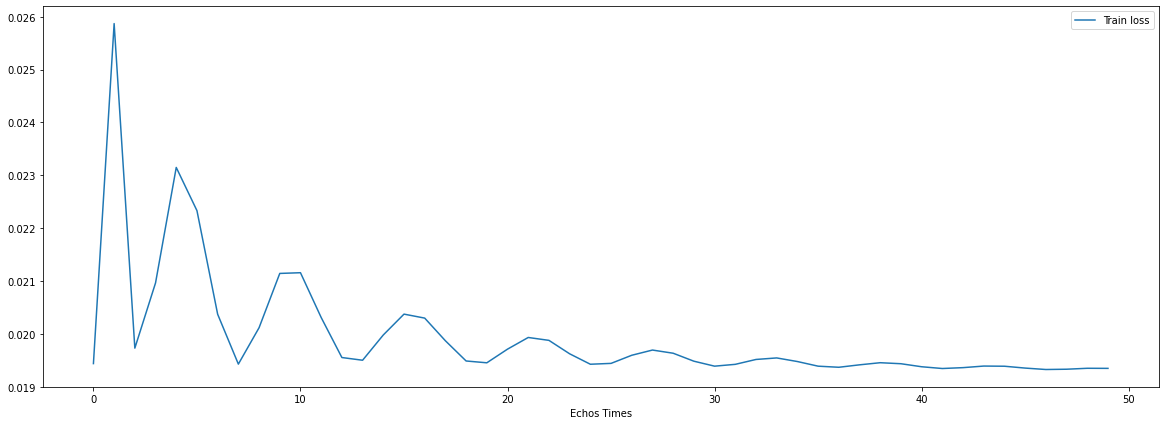

In [33]:
myplot.model_loss({"Train loss":train_hist_geo}, save_name=path+"geo_loss.png")

## Semigeo Features

In [37]:
model_semigeo = MLP_Regression(
  input_size=50,
  hidden_size=1000
)

In [38]:
k_scores = timeseries_kfold_validation_training(df=df_train, features=semigeo_cols, target=target, n_groups=n_groups, model=model_semigeo, lr=lr, num_epochs=num_epochs)

Epoch 0 train loss: 0.11563533544540405 test loss: 0.11023296415805817
Epoch 10 train loss: 0.04165796563029289 test loss: 0.03664550557732582
Epoch 20 train loss: 0.031024055555462837 test loss: 0.030682014301419258
Epoch 30 train loss: 0.03001953661441803 test loss: 0.028545955196022987
Epoch 40 train loss: 0.02943459525704384 test loss: 0.028854602947831154
Epoch 49 train loss: 0.028957098722457886 test loss: 0.027883723378181458
Epoch 0 train loss: 0.030216695740818977 test loss: 0.016311246901750565
Epoch 10 train loss: 0.03025805577635765 test loss: 0.018872138112783432
Epoch 20 train loss: 0.0295464638620615 test loss: 0.01848205365240574
Epoch 30 train loss: 0.028934970498085022 test loss: 0.017682410776615143
Epoch 40 train loss: 0.02846376597881317 test loss: 0.017341623082756996
Epoch 49 train loss: 0.028087683022022247 test loss: 0.017313972115516663
Epoch 0 train loss: 0.028573881834745407 test loss: 0.01238348986953497
Epoch 10 train loss: 0.02934494987130165 test loss: 0

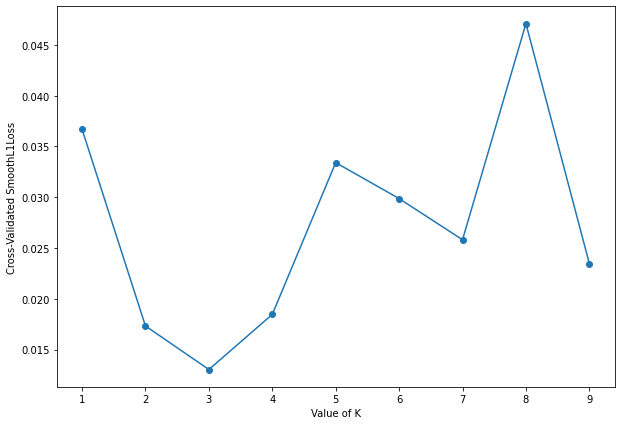

<Figure size 432x288 with 0 Axes>

In [39]:
myplot.k_fold_validation(n_groups, k_scores, save_name=path+"semigeo_k_fold.png")

### Train model

In [40]:
x_train, y_train = df_train[semigeo_cols].values, df_train[target].values
x_train_tensor = torch.tensor(x_train, dtype = torch.float)
y_train_tensor = torch.tensor(y_train, dtype = torch.float)

In [41]:
model_semigeo, train_hist_semigeo, _ = train_model(model_semigeo, 
                                            lr,
                                            num_epochs,
                                            x_train_tensor, 
                                            y_train_tensor,
                                            save_name=path+"semigeo_model.pth")

Epoch 0 train loss: 0.022592192515730858
Epoch 10 train loss: 0.02324812300503254
Epoch 20 train loss: 0.022943131625652313
Epoch 30 train loss: 0.022594962269067764
Epoch 40 train loss: 0.02236727438867092


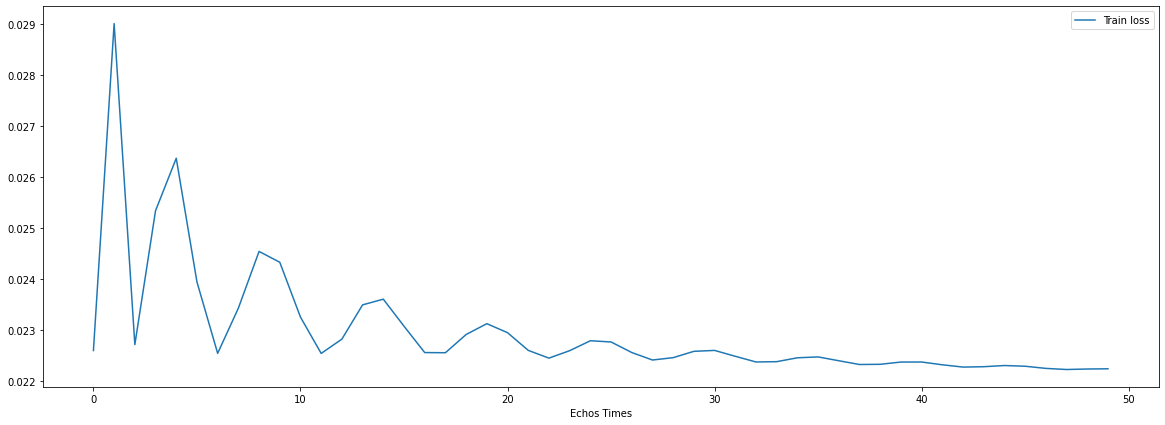

In [42]:
myplot.model_loss({"Train loss":train_hist_semigeo}, save_name=path+"semigeo_loss.png")